#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행 
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

* 함수 생성

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [3]:
data_path = os.path.join(os.getcwd(), 'data/data01_train.csv')
data = pd.read_csv(data_path)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [4]:
data = data.drop('subject', axis=1)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


#### 2) 기본 정보 조회

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [6]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [7]:
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

In [8]:
data.isnull()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5877,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5878,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5879,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
nan_counts = data.isna().sum()
nan_cols = nan_counts[nan_counts > 0].index.tolist()
print("NaN 존재하는 column:", nan_cols)

NaN 존재하는 column: []


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다. 


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

### - 'WALKING': 0,
### - 'WALKING_UPSTAIRS': 1,
### - 'WALKING_DOWNSTAIRS': 2,
### - 'LAYING': 3,
### - 'STANDING': 4,
### - 'SITTING': 5 

In [10]:
data['Activity_num'] = data['Activity'].map({'WALKING': 0,
                                             'WALKING_UPSTAIRS': 1,
                                             'WALKING_DOWNSTAIRS': 2,
                                             'LAYING': 3,
                                             'STANDING': 4,
                                             'SITTING': 5 })
X = data.drop('Activity_num', axis=1)
X = X.drop('Activity', axis=1)
y = data['Activity_num']

In [11]:
X.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.050888,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.013902,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758


In [12]:
y.head()

0    4
1    3
2    4
3    0
4    2
Name: Activity_num, dtype: int64

In [13]:
data['Activity'].head()

0              STANDING
1                LAYING
2              STANDING
3               WALKING
4    WALKING_DOWNSTAIRS
Name: Activity, dtype: object

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [15]:
# data가 약 6000개로 많지 않기 때문에 8:2로 분할함
# random_state=42 고정
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다. 
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : RandomForest
### (2) 알고리즘2 : LightGBM
### (3) 알고리즘3 : XGB
### (4) 알고리즘4 : CatBoost

#### Model Definition

In [16]:
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(objective='multiclass', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, loss_function='MultiClass', random_state=42)
}

#### Model Training and Evaluation
- 이 과정에서 feature importance를 따로 저장해 관리

In [17]:
results = {}
importances = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)
    
    acc = accuracy_score(y_valid, y_pred)
    cm = confusion_matrix(y_valid, y_pred)
    clf_report = classification_report(y_valid, y_pred, output_dict=True)
    
    results[name] = {
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': clf_report
    }
    
    # feature importance 저장
    # LightGBM, RandomForest, XGBoost, CatBoost 모두 feature importance 기능 제공
    if hasattr(model, 'feature_importances_'):
        importances[name] = model.feature_importances_


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140145
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 561
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925291
[LightGBM] [Info] Start training from score -2.005698
[LightGBM] [Info] Start training from score -1.662702
[LightGBM] [Info] Start training from score -1.688825
[LightGBM] [Info] Start training from score -1.739574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

#### Validation Result Visualization

In [18]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [19]:
def plot_roc_curve(models, X_valid_scaled, y_valid):
    plt.figure(figsize=(8, 6))
    
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_valid_scaled)
            fpr, tpr, _ = roc_curve(y_valid, y_prob[:, 1], pos_label=1)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

각 모델의 성능을 저장해 이를 비교하기 위한 별도 dataframe

In [20]:
df_path = os.path.join(os.getcwd(), 'model_comparison_df')
performance_all_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])


===== RandomForest =====
Accuracy: 0.9754

Classification Report:
              precision    recall  f1-score      support
0              0.994898  0.975000  0.984848   200.000000
1              0.960674  0.994186  0.977143   172.000000
2              0.980892  0.974684  0.977778   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.954545  0.963303  0.958904   218.000000
5              0.960591  0.946602  0.953545   206.000000
accuracy       0.975361  0.975361  0.975361     0.975361
macro avg      0.975267  0.975629  0.975370  1177.000000
weighted avg   0.975505  0.975361  0.975360  1177.000000


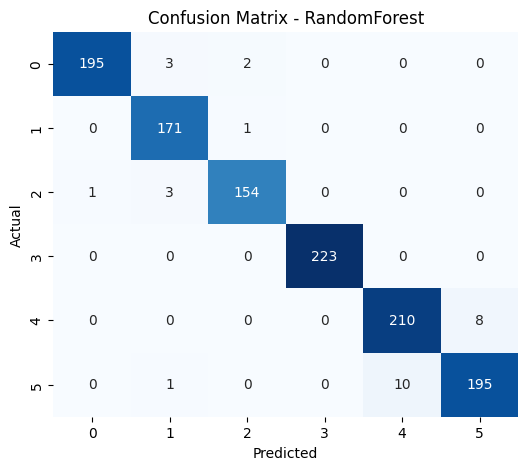


===== LightGBM =====
Accuracy: 0.9881

Classification Report:
              precision    recall  f1-score      support
0              0.995025  1.000000  0.997506   200.000000
1              0.988372  0.988372  0.988372   172.000000
2              0.993671  0.993671  0.993671   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.977064  0.977064  0.977064   218.000000
5              0.975610  0.970874  0.973236   206.000000
accuracy       0.988105  0.988105  0.988105     0.988105
macro avg      0.988290  0.988330  0.988308  1177.000000
weighted avg   0.988089  0.988105  0.988095  1177.000000


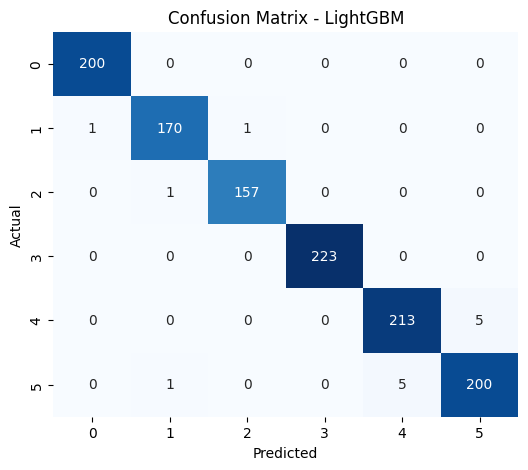


===== XGBoost =====
Accuracy: 0.9915

Classification Report:
              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000   200.000000
1              1.000000  1.000000  1.000000   172.000000
2              1.000000  1.000000  1.000000   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.972727  0.981651  0.977169   218.000000
5              0.980392  0.970874  0.975610   206.000000
accuracy       0.991504  0.991504  0.991504     0.991504
macro avg      0.992187  0.992088  0.992130  1177.000000
weighted avg   0.991517  0.991504  0.991502  1177.000000


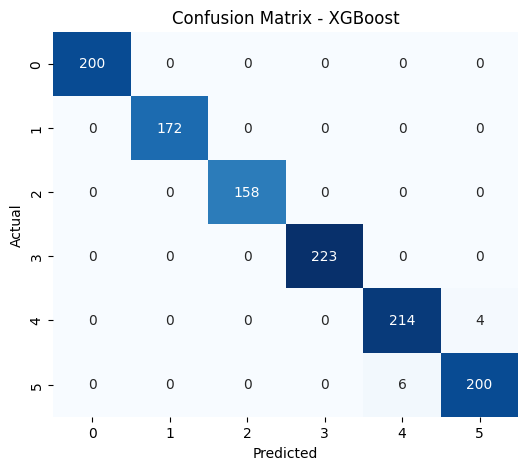


===== CatBoost =====
Accuracy: 0.9924

Classification Report:
              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000   200.000000
1              0.994220  1.000000  0.997101   172.000000
2              1.000000  1.000000  1.000000   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.977273  0.986239  0.981735   218.000000
5              0.985222  0.970874  0.977995   206.000000
accuracy       0.992353  0.992353  0.992353     0.992353
macro avg      0.992786  0.992852  0.992805  1177.000000
weighted avg   0.992359  0.992353  0.992342  1177.000000


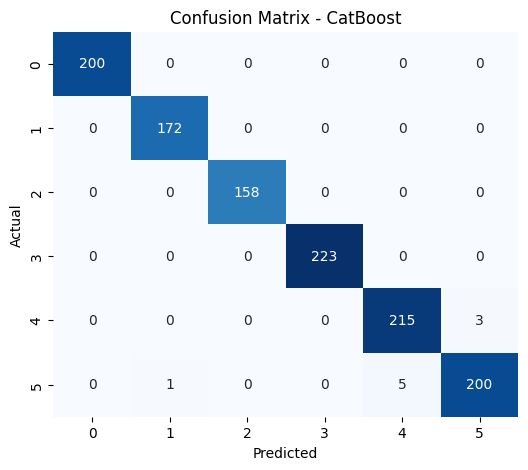

In [31]:
for model_name, result in results.items():
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {result['accuracy']:.4f}")
    
    print("\nClassification Report:")
    clf_report_df = pd.DataFrame(result['classification_report']).transpose()
    print(clf_report_df)
    
    # Confusion Matrix Plot
    plot_confusion_matrix(result['confusion_matrix'], model_name)

    # Dataframe for model performance comparison
    accuracy = result['accuracy']
    macro_avg = clf_report_df.loc['macro avg', ['precision', 'recall', 'f1-score']].to_dict()
    
    performance_all_data = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': macro_avg['precision'],
        'Recall': macro_avg['recall'],
        'F1-Score': macro_avg['f1-score']
    }
    
    performance_all_df = pd.concat([performance_all_df, pd.DataFrame([performance_all_data])], ignore_index=True)

# 성능 데이터프레임을 CSV 파일로 저장
performance_all_df.to_csv(os.path.join(df_path, 'model_performance_all_features.csv'), index=False)

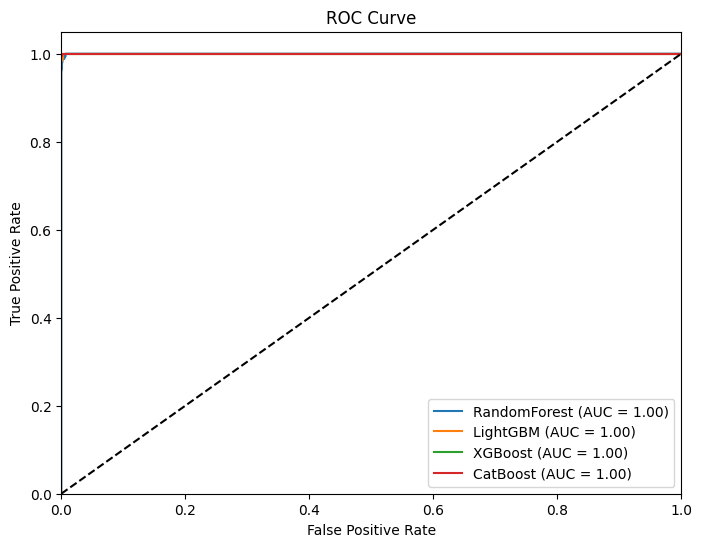

In [32]:
plot_roc_curve(models, X_valid_scaled, y_valid)

### 현재 dataset에서 전체 variable로 modeling한 결과, catboost가 가장 좋은 성능을 보이고 있다

#### 학습 과정에서 따로 저장한 feature importance를 가지고 이를 시각화

In [33]:
def plot_FI(importances, feature_names, model_name):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importance - {model_name}')
    plt.bar(range(len(importances)), importances[indices], color='b', align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

for model_name, importance in importances.items():
    plot_feature_importance(importance, X.columns, model_name)

#### feature의 개수가 많아 threshold를 지정해 가독성 높임

In [34]:
def plot_FI_with_threshold(importances, feature_names, model_name, threshold=None):
    # model마다 fi가 저장되는 값의 scale이 다르기에 각각 지정
    if threshold is None:
        threshold = 0.005
    if model_name == 'LightGBM':
        threshold = 100
    elif model_name == 'CatBoost':
        threshold = 1

    
    # Thresholding
    important_indices = np.where(importances > threshold)[0]
    importances = importances[important_indices]
    features = feature_names[important_indices]

    # Sorting
    sorted_idx = np.argsort(importances)[::-1]
    important_importances = importances[sorted_idx]
    important_features = features[sorted_idx]

    if len(important_importances) > 0:
        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importance - {model_name} (Threshold > {threshold})')
        plt.bar(range(len(important_importances)), important_importances, color='b', align='center')
        plt.xticks(range(len(important_features)), important_features, rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No features passed the importance threshold of {threshold}.")

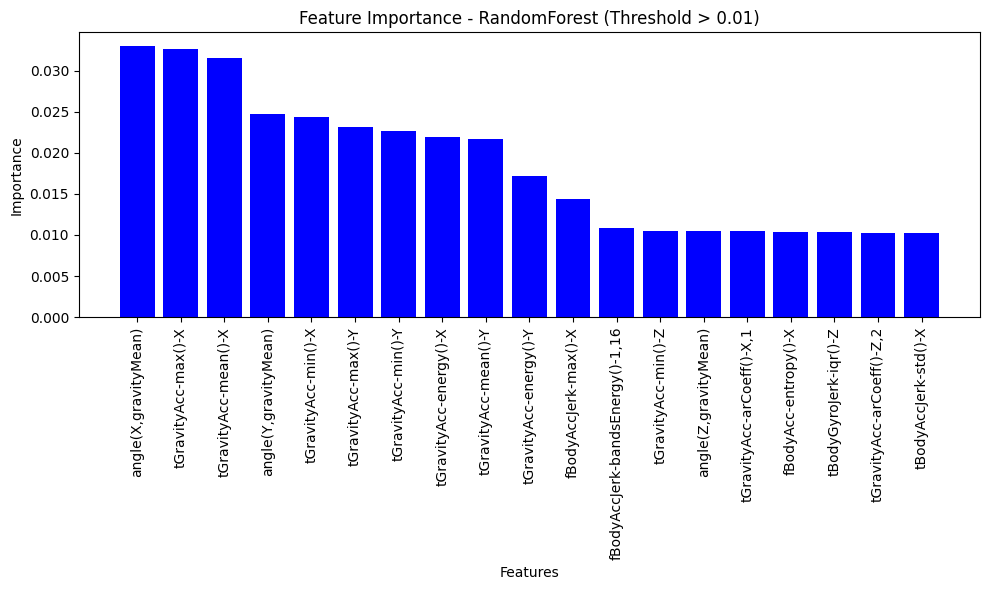

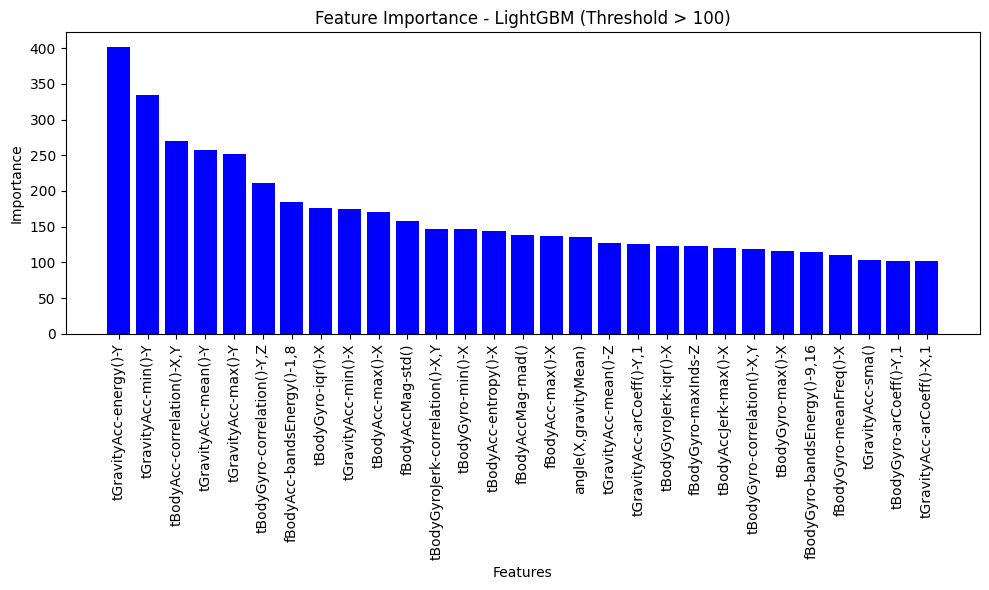

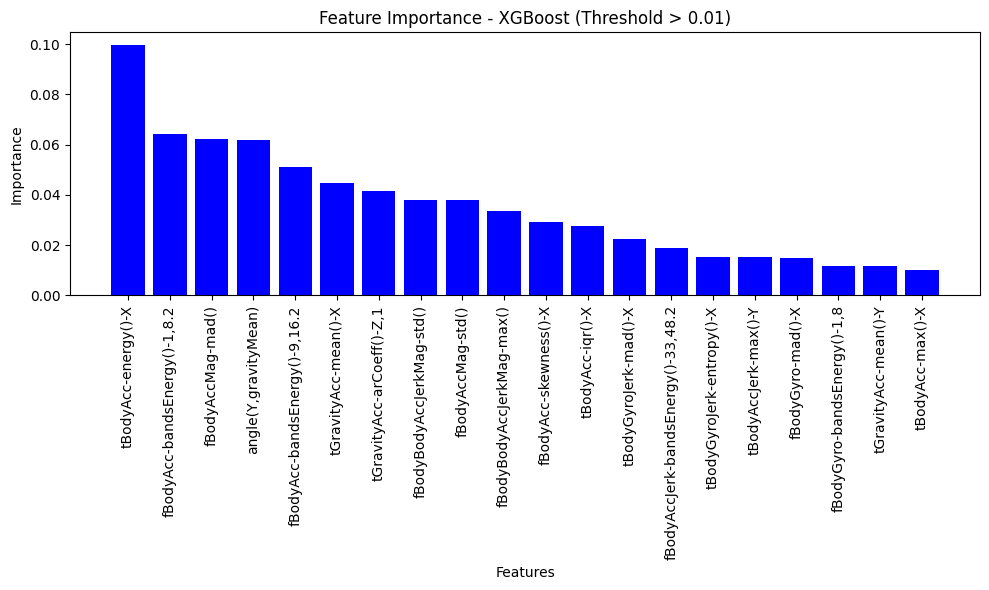

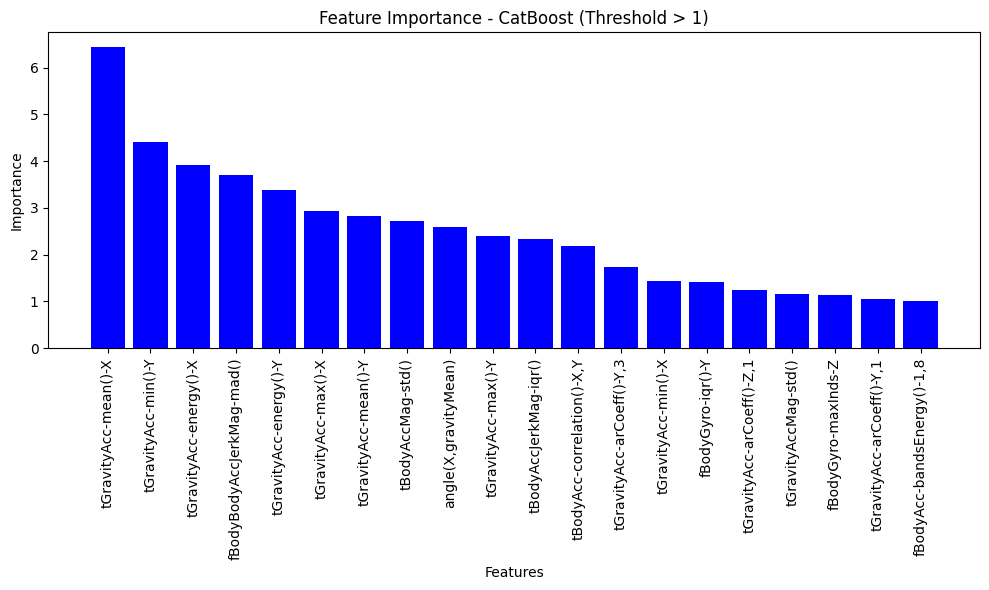

In [35]:
for model_name, importance in importances.items():
    plot_FI_with_threshold(importance, X.columns, model_name, threshold=0.01)

### Feature Importance Top-20에 대해 다시 Training and Evaluation
- 상위 20개 정도의 feature가 적당해 보였음

In [36]:
N = 20
performance_topN_df = pd.DataFrame(columns=['Model', 'Top_N_Features', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])


===== RandomForest: Top 20 Features =====
['tGravityAcc-mean()-Z', 'tBodyAccJerk-std()-X', 'tGravityAcc-arCoeff()-Z,2', 'tBodyGyroJerk-iqr()-Z', 'fBodyAcc-entropy()-X', 'tGravityAcc-arCoeff()-X,1', 'angle(Z,gravityMean)', 'tGravityAcc-min()-Z', 'fBodyAccJerk-bandsEnergy()-1,16', 'fBodyAccJerk-max()-X', 'tGravityAcc-energy()-Y', 'tGravityAcc-mean()-Y', 'tGravityAcc-energy()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-max()-Y', 'tGravityAcc-min()-X', 'angle(Y,gravityMean)', 'tGravityAcc-mean()-X', 'tGravityAcc-max()-X', 'angle(X,gravityMean)']
Accuracy with top 20 features: 0.9592

Classification Report:
              precision    recall  f1-score      support
0              0.933673  0.915000  0.924242   200.000000
1              0.954286  0.970930  0.962536   172.000000
2              0.911950  0.917722  0.914826   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.985782  0.954128  0.969697   218.000000
5              0.953052  0.985437  0.968974   206.0

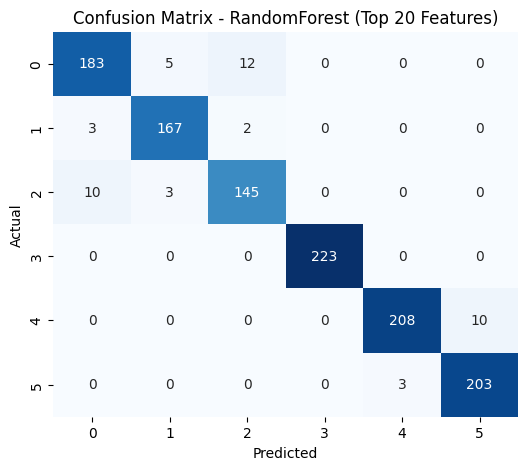


===== LightGBM: Top 20 Features =====
['fBodyGyro-maxInds-Z', 'tGravityAcc-arCoeff()-Y,1', 'tGravityAcc-mean()-Z', 'angle(X,gravityMean)', 'fBodyAcc-max()-X', 'fBodyAccMag-mad()', 'tBodyAcc-entropy()-X', 'tBodyGyro-min()-X', 'tBodyGyroJerk-correlation()-X,Y', 'fBodyAccMag-std()', 'tBodyAcc-max()-X', 'tGravityAcc-min()-X', 'tBodyGyro-iqr()-X', 'fBodyAcc-bandsEnergy()-1,8', 'tBodyGyro-correlation()-Y,Z', 'tGravityAcc-max()-Y', 'tGravityAcc-mean()-Y', 'tBodyAcc-correlation()-X,Y', 'tGravityAcc-min()-Y', 'tGravityAcc-energy()-Y']
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 20
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925291
[LightGBM] [Info] Start training from score -2.005698
[LightGBM] [Info]

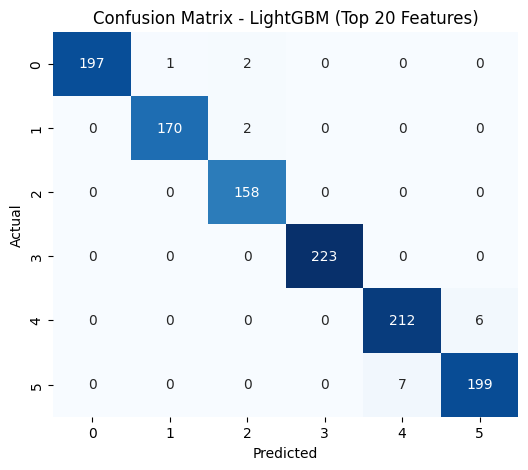


===== XGBoost: Top 20 Features =====
['tBodyAcc-max()-X', 'tGravityAcc-mean()-Y', 'fBodyGyro-bandsEnergy()-1,8', 'fBodyGyro-mad()-X', 'tBodyAccJerk-max()-Y', 'tBodyGyroJerk-entropy()-X', 'fBodyAccJerk-bandsEnergy()-33,48.2', 'tBodyGyroJerk-mad()-X', 'tBodyAcc-iqr()-X', 'fBodyAcc-skewness()-X', 'fBodyBodyAccJerkMag-max()', 'fBodyAccMag-std()', 'fBodyBodyAccJerkMag-std()', 'tGravityAcc-arCoeff()-Z,1', 'tGravityAcc-mean()-X', 'fBodyAcc-bandsEnergy()-9,16.2', 'angle(Y,gravityMean)', 'fBodyAccMag-mad()', 'fBodyAcc-bandsEnergy()-1,8.2', 'tBodyAcc-energy()-X']
Accuracy with top 20 features: 0.9754

Classification Report:
              precision    recall  f1-score      support
0              0.980296  0.995000  0.987593   200.000000
1              0.965909  0.988372  0.977011   172.000000
2              0.986842  0.949367  0.967742   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.946667  0.977064  0.961625   218.000000
5              0.974747  0.936893  

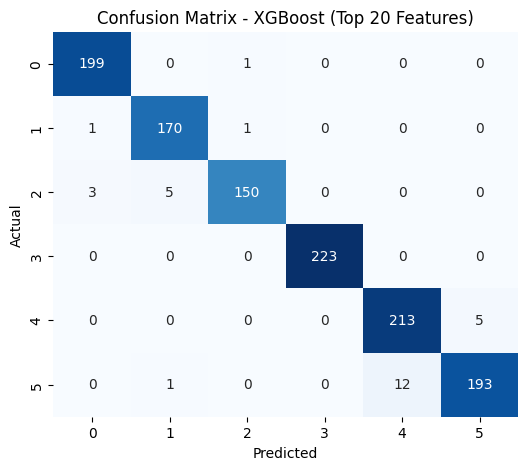


===== CatBoost: Top 20 Features =====
['fBodyAcc-bandsEnergy()-1,8', 'tGravityAcc-arCoeff()-Y,1', 'fBodyGyro-maxInds-Z', 'tGravityAccMag-std()', 'tGravityAcc-arCoeff()-Z,1', 'fBodyGyro-iqr()-Y', 'tGravityAcc-min()-X', 'tGravityAcc-arCoeff()-Y,3', 'tBodyAcc-correlation()-X,Y', 'tBodyAccJerkMag-iqr()', 'tGravityAcc-max()-Y', 'angle(X,gravityMean)', 'tBodyAccMag-std()', 'tGravityAcc-mean()-Y', 'tGravityAcc-max()-X', 'tGravityAcc-energy()-Y', 'fBodyBodyAccJerkMag-mad()', 'tGravityAcc-energy()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-mean()-X']
Accuracy with top 20 features: 0.9762

Classification Report:
              precision    recall  f1-score      support
0              0.985075  0.990000  0.987531   200.000000
1              0.982759  0.994186  0.988439   172.000000
2              0.993590  0.981013  0.987261   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.957944  0.940367  0.949074   218.000000
5              0.942584  0.956311  0.949398   206.

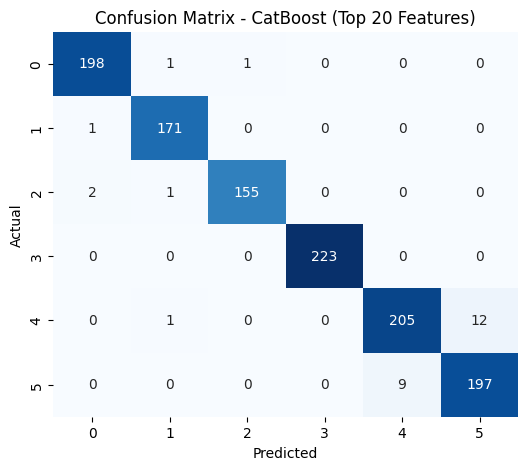

In [37]:
for model_name, importance in importances.items():
    # 상위 N개 변수 선택
    top_N_features = np.argsort(importance)[-N:]
    
    # 선택된 변수명 출력
    selected_features = [X.columns[i] for i in top_N_features]
    print(f"\n===== {model_name}: Top {N} Features =====")
    print(selected_features)

    # 상위 N개 변수로 데이터 재구성
    X_train_topN = X_train_scaled[:, top_N_features]
    X_valid_topN = X_valid_scaled[:, top_N_features]
    
    # 모델 재학습 및 평가
    model = models[model_name]
    model.fit(X_train_topN, y_train)
    y_pred = model.predict(X_valid_topN)
    
    # 성능 계산
    acc = accuracy_score(y_valid, y_pred)
    clf_report_dict = classification_report(y_valid, y_pred, output_dict=True)

    # 주요 지표 저장 (Accuracy, Precision, Recall, F1-Score for 'macro avg')
    clf_report_df = pd.DataFrame(clf_report_dict).transpose()
    macro_avg = clf_report_df.loc['macro avg', ['precision', 'recall', 'f1-score']].to_dict()
    
    # 성능 데이터를 통합해 새로운 row 생성
    performance_data = {
        'Model': model_name,
        'Top_N_Features': N,
        'Accuracy': acc,
        'Precision': macro_avg['precision'],
        'Recall': macro_avg['recall'],
        'F1-Score': macro_avg['f1-score']
    }
    
    # 성능 데이터를 데이터프레임으로 변환 후 concat으로 추가
    performance_topN_df = pd.concat([performance_topN_df, pd.DataFrame([performance_data])], ignore_index=True)
    
    print(f"Accuracy with top {N} features: {acc:.4f}")
    print("\nClassification Report:")
    print(pd.DataFrame(clf_report_dict).transpose())

    # Confusion Matrix Plot
    plot_confusion_matrix(confusion_matrix(y_valid, y_pred), f'{model_name} (Top {N} Features)')

# 성능 데이터를 CSV 파일로 저장
performance_topN_df.to_csv(os.path.join(df_path, f'model_performance_top{N}_features.csv'), index=False)

### Performance Comparison
- 각 모델의 성능을 저장한 Dataframe 불러와 비교
    - 전체 feature에 대해 학습한 모델들의 성능 vs feature importance가 상위 20에 대해 학습한 모델들의 성능

In [38]:
df_all = pd.read_csv(os.path.join(df_path, 'model_performance_all_features.csv'))
df_all.head()

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest,0.975361,0.975267,0.975629,0.975370
1,LightGBM,0.988105,0.988290,0.988330,0.988308
2,XGBoost,0.991504,0.992187,0.992088,0.992130
3,CatBoost,0.992353,0.992786,0.992852,0.992805
4,RandomForest,0.975361,0.975267,0.975629,0.975370


In [39]:
df_top20 = pd.read_csv(os.path.join(df_path, 'model_performance_top20_features.csv'))
df_top20.head()

,Model,Top_N_Features,Accuracy,Precision,Recall,F1-Score
0,RandomForest,20,0.959218,0.956457,0.957203,0.956713
1,LightGBM,20,0.984707,0.984705,0.985311,0.984970
2,XGBoost,20,0.975361,0.975743,0.974449,0.974903
3,CatBoost,20,0.976211,0.976992,0.976979,0.976951


## Result
```Random Forest```
- Accuacy: 0.9754 -> 0.9592
- Macro Avg f1-score: 0.9753 0> 0.9567</br>

```LightGBM```
- Accuacy: 0.9881 -> 0.9847
- Macro Avg f1-score: 0.9883 0> 0.9850</br>

```XGBoost```
- Accuacy: 0.9915 -> 0.9754
- Macro Avg f1-score: 0.9921 -> 0.9749</br>

```CatBoost```
- Accuacy: 0.9924 -> 0.9762
- Macro Avg f1-score: 0.9928 -> 0.9770</br>

### Discussion
- 전체 feature로 학습시켰을 땐 CatBoost가 accuarcy나 macro avg에 대한 f1-score로 보나 가장 성능이 좋았지만, 상위 20개의 feature로 학습한 결과 성능이 떨어졌다.
- CatBoost 뿐만 아니라 다른 알고리즘도 마찬가지긴 했지만 ```LightGBM```은 성능 하락폭이 상대적으로 작은 모습을 보여줬다.

-----------------------------------------------------------------------------------------------------

# Option
#### 지금까지의 결과로 LightGBM은 TOP-N개의 feaure로 학습해도 크게 성능이 떨어지지 않는다는 사실을 알아냄.
## **LightGBM**
- **LightGBM**은 XGBoost보다 정확도는 떨어질 수 있어도 훨씬 빠르다는 장점 때문에 유용하게 쓰인다.
- 효율적이고 빠른 학습을 위해 **LightGBM**을 통해 $N_{optimal}$을 구해보겠다.


LightGBM 모델에서 feature importance 추출 후 sort

In [105]:
lightgbm_importances = importances['LightGBM']
importance_indices = np.argsort(lightgbm_importances)[::-1]

Threshold를 지정해 정확도 변화가 없을 경우 중단

In [106]:
def find_optimal_N(X_train_scaled, X_valid_scaled, y_train, y_valid, importances, threshold=0.0001):
    performance_comparison = []
    
    for N in range(1, len(importances) + 1):
        top_N_features = importance_indices[:N]
        
        X_train_topN = X_train_scaled[:, top_N_features]
        X_valid_topN = X_valid_scaled[:, top_N_features]
        
        model = LGBMClassifier(objective='multiclass', random_state=42)
        model.fit(X_train_topN, y_train)
        
        y_pred = model.predict(X_valid_topN)
        acc = accuracy_score(y_valid, y_pred)
        
        performance_comparison.append((N, acc))
        
        if N > 1 and abs(performance_comparison[N-1][1] - performance_comparison[N-2][1]) < threshold:
            print(f"Optimal N found: {N} (Accuracy: {acc:.4f})")
            return N
    
    return None

In [107]:
sub_optimal_N = find_optimal_N(X_train_scaled, X_valid_scaled, y_train, y_valid, lightgbm_importances, threshold=0.001)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 1
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925291
[LightGBM] [Info] Start training from score -2.005698
[LightGBM] [Info] Start training from score -1.662702
[LightGBM] [Info] Start training from score -1.688825
[LightGBM] [Info] Start training from score -1.739574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 2
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925

In [108]:
print(sub_optimal_N)

10


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 10
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925291
[LightGBM] [Info] Start training from score -2.005698
[LightGBM] [Info] Start training from score -1.662702
[LightGBM] [Info] Start training from score -1.688825
[LightGBM] [Info] Start training from score -1.739574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

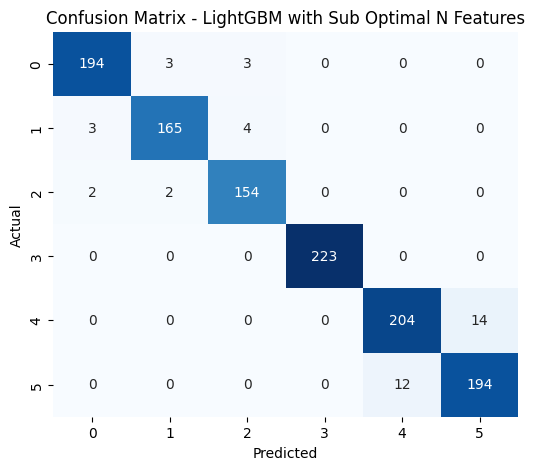


Classification Report for Sub Optimal N Features:
              precision    recall  f1-score      support
0              0.974874  0.970000  0.972431   200.000000
1              0.970588  0.959302  0.964912   172.000000
2              0.956522  0.974684  0.965517   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.944444  0.935780  0.940092   218.000000
5              0.932692  0.941748  0.937198   206.000000
accuracy       0.963466  0.963466  0.963466     0.963466
macro avg      0.963187  0.963586  0.963358  1177.000000
weighted avg   0.963526  0.963466  0.963471  1177.000000


In [109]:
sub_top_N_features = importance_indices[:sub_optimal_N]
X_train_sub_topN = X_train_scaled[:, sub_top_N_features]
X_valid_sub_topN = X_valid_scaled[:, sub_top_N_features]

sub_optimal_model = LGBMClassifier(objective='multiclass', random_state=42)
sub_optimal_model.fit(X_train_sub_topN, y_train)

y_pred_sub_optimal = sub_optimal_model.predict(X_valid_sub_topN)

sub_cm = confusion_matrix(y_valid, y_pred_sub_optimal)

plot_confusion_matrix(sub_cm, 'LightGBM with Sub Optimal N Features')

print("\nClassification Report for Sub Optimal N Features:")
sub_clf_report = classification_report(y_valid, y_pred_sub_optimal, output_dict=True)
sub_clf_report_df = pd.DataFrame(sub_clf_report).transpose()
print(sub_clf_report_df)

#### Threshold를 0.001로 잡았더니 $N_{optimal}$=10이 나오며 생각보단 만족스럽지 않은 결과가 나와 Threshold를 0.0001로 조정

In [110]:
optimal_N = find_optimal_N(X_train_scaled, X_valid_scaled, y_train, y_valid, lightgbm_importances, threshold=0.0001)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 1
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925291
[LightGBM] [Info] Start training from score -2.005698
[LightGBM] [Info] Start training from score -1.662702
[LightGBM] [Info] Start training from score -1.688825
[LightGBM] [Info] Start training from score -1.739574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 2
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925

In [111]:
print(optimal_N)

24


$N_{optimal}$로 학습 후 confusion matrix 출력

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5887
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 24
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925291
[LightGBM] [Info] Start training from score -2.005698
[LightGBM] [Info] Start training from score -1.662702
[LightGBM] [Info] Start training from score -1.688825
[LightGBM] [Info] Start training from score -1.739574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

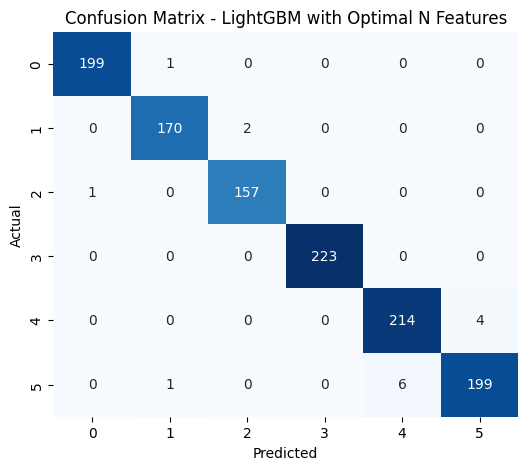


Classification Report for Optimal N Features:
              precision    recall  f1-score      support
0              0.995000  0.995000  0.995000   200.000000
1              0.988372  0.988372  0.988372   172.000000
2              0.987421  0.993671  0.990536   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.972727  0.981651  0.977169   218.000000
5              0.980296  0.966019  0.973105   206.000000
accuracy       0.987256  0.987256  0.987256     0.987256
macro avg      0.987303  0.987452  0.987364  1177.000000
weighted avg   0.987263  0.987256  0.987245  1177.000000


In [112]:
if optimal_N is not None:
    top_N_features = importance_indices[:optimal_N]
    X_train_topN = X_train_scaled[:, top_N_features]
    X_valid_topN = X_valid_scaled[:, top_N_features]
    
    optimal_model = LGBMClassifier(objective='multiclass', random_state=42)
    optimal_model.fit(X_train_topN, y_train)
    
    y_pred_optimal = optimal_model.predict(X_valid_topN)
    
    cm = confusion_matrix(y_valid, y_pred_optimal)
    
    plot_confusion_matrix(cm, 'LightGBM with Optimal N Features')

    print("\nClassification Report for Optimal N Features:")
    clf_report = classification_report(y_valid, y_pred_optimal, output_dict=True)
    clf_report_df = pd.DataFrame(clf_report).transpose()
    print(clf_report_df)
else:
    print("No optimal N found within the specified threshold.")

# Result

```Previous Result```
- All features
    - Accuacy: 0.9881
    - Macro Avg f1-score: 0.9883
- Top 20 features
    - Accuacy: 0.9847
    - Macro Avg f1-score: 0.98

```Threshold = 0.001```
- $N_{optimal}$=10
    - Accuacy: 0.9635
    - Macro Avg f1-score: 0.96336

```Threshold = 0.0001```
- $N_{optimal}$=24
        - Accuacy: 0.9873
    - Macro Avg f1-score: 0.9874

## **N=24**일 때 가장 효율적이고 효과적인 성능의 LightGBM을 얻을 수 있다는 실험결과를 얻어냈다.
### 물론, 자원과 시간이 여유롭다면, 현재 dataset에서는 ***전체 feature로 학습한 catboost가 가장 효과적***일 것으로 예상된다.
-> 이 사실을 바탕으로 마지막 pipeline을 구성하고자 한다.

--------------------------------------------------------------------------------------------------------------------

# Ablation Study
#### 이 과제를 진행하며 계속 드는 의문이 있다.
## "내가 사용한 알고리즘들에 대해 과연 Scaling을 통한 Normalization이 필수적이었는가?"
이를 알아보기 위해 정규화하지 않은 전체 feature에 대해 다시 4가지 알고리즘을 학습시켰다.
- 전체 feature에 대해 학습한 결과를 비교

In [128]:
X = data.drop(['Activity_num', 'Activity'], axis=1)
y = data['Activity_num']

### 이제보니 StandardSclaer를 통해 Numpy array로 읽어와 학습시키다보니 별다른 문제가 없었지만 그냥 학습하면 feature의 형식으로 인한 오류가 발생한다.
> LightGBMError: Do not support special JSON characters in feature name.
-> 이를 해결하고 학습을 진행

In [129]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_np = X_train.to_numpy()
X_valid_np = X_valid.to_numpy()
y_train_np = y_train.to_numpy()
y_valid_np = y_valid.to_numpy()

In [130]:
unscaled_results = {}

for name, model in models.items():
    model.fit(X_train_np, y_train_np)
    unscaled_y_pred = model.predict(X_valid_np)
    
    acc = accuracy_score(y_valid_np, unscaled_y_pred)
    cm = confusion_matrix(y_valid_np, y_pred)
    clf_report = classification_report(y_valid_np, unscaled_y_pred, output_dict=True)
    
    unscaled_results[name] = {
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': clf_report
    }

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140139
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 561
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925291
[LightGBM] [Info] Start training from score -2.005698
[LightGBM] [Info] Start training from score -1.662702
[LightGBM] [Info] Start training from score -1.688825
[LightGBM] [Info] Start training from score -1.739574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]


===== RandomForest =====
Accuracy: 0.9771

Classification Report:
              precision    recall  f1-score     support
0              0.980000  0.980000  0.980000   200.00000
1              0.966102  0.994186  0.979943   172.00000
2              0.980519  0.955696  0.967949   158.00000
3              1.000000  1.000000  1.000000   223.00000
4              0.967890  0.967890  0.967890   218.00000
5              0.965854  0.961165  0.963504   206.00000
accuracy       0.977060  0.977060  0.977060     0.97706
macro avg      0.976727  0.976490  0.976547  1177.00000
weighted avg   0.977109  0.977060  0.977033  1177.00000


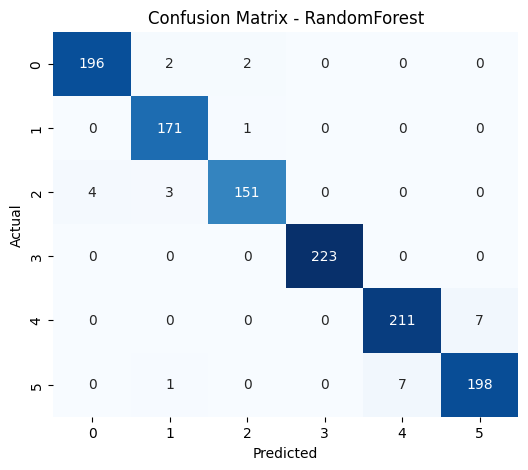


===== LightGBM =====
Accuracy: 0.9907

Classification Report:
              precision    recall  f1-score      support
0              0.995025  1.000000  0.997506   200.000000
1              0.994152  0.988372  0.991254   172.000000
2              0.993671  0.993671  0.993671   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.981651  0.981651  0.981651   218.000000
5              0.980583  0.980583  0.980583   206.000000
accuracy       0.990654  0.990654  0.990654     0.990654
macro avg      0.990847  0.990713  0.990777  1177.000000
weighted avg   0.990653  0.990654  0.990652  1177.000000


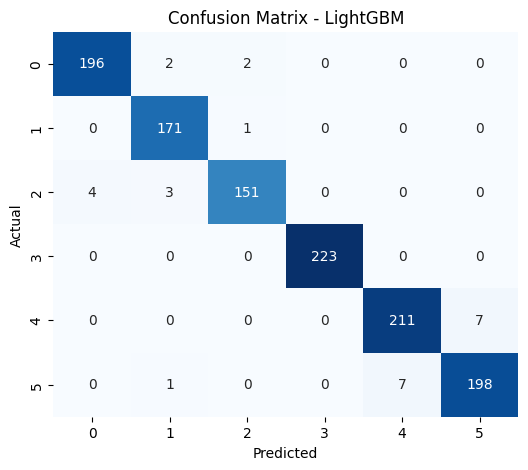


===== XGBoost =====
Accuracy: 0.9924

Classification Report:
              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000   200.000000
1              1.000000  1.000000  1.000000   172.000000
2              1.000000  1.000000  1.000000   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.977169  0.981651  0.979405   218.000000
5              0.980488  0.975728  0.978102   206.000000
accuracy       0.992353  0.992353  0.992353     0.992353
macro avg      0.992943  0.992897  0.992918  1177.000000
weighted avg   0.992356  0.992353  0.992353  1177.000000


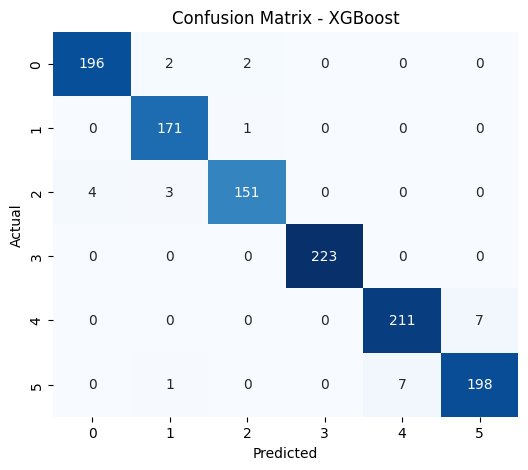


===== CatBoost =====
Accuracy: 0.9907

Classification Report:
              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000   200.000000
1              0.994220  1.000000  0.997101   172.000000
2              1.000000  1.000000  1.000000   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.972727  0.981651  0.977169   218.000000
5              0.980296  0.966019  0.973105   206.000000
accuracy       0.990654  0.990654  0.990654     0.990654
macro avg      0.991207  0.991278  0.991229  1177.000000
weighted avg   0.990655  0.990654  0.990641  1177.000000


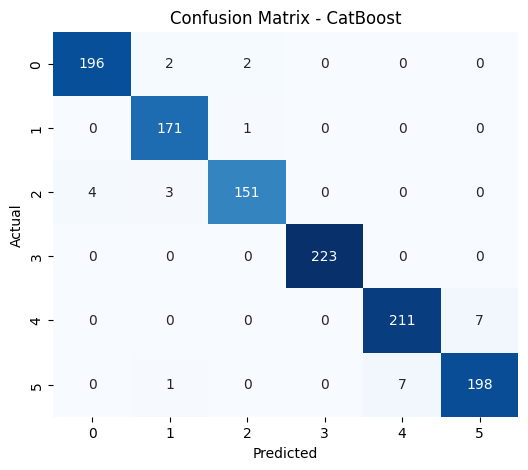

In [131]:
for model_name, result in unscaled_results.items():
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {result['accuracy']:.4f}")
    
    print("\nClassification Report:")
    unscaled_clf_report_df = pd.DataFrame(result['classification_report']).transpose()
    print(unscaled_clf_report_df)
    
    # Confusion Matrix Plot
    plot_confusion_matrix(result['confusion_matrix'], model_name)

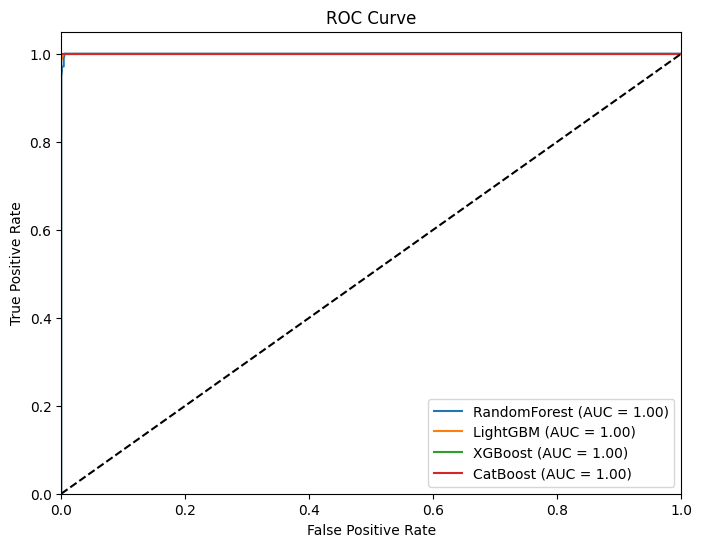

In [133]:
plot_roc_curve(models, X_valid_np, y_valid)

### RandomForest, LightGBM, XGBoost는 소폭 상승한 반면, CatBoost는 소폭 하락함
- 과제 1에서 kde를 통한 단변량 그래프 시각화 결과, 대부분의 상위 FI feature의 data가 Gaussian Distribution을 따르기에 굳이 Normalization을 해주지 않아도 될 것이라 생각해 이번 실험을 진행했음.
- CatBoost를 제외한 다른 ML model에서는 소폭 상승했지만 유망주였던 CatBoost가 하락해 매우 당황스러운 결과임.

## Discussion
- RandomForest, LightGBM, XGBoost는 scaling의 영향을 덜 받기 때문에 성능이 소폭 상승한 것으로 보임
- 반면, CatBoost는 scaling에 더 민감하여 성능이 하락한 것으로 보임


추후 진행할 과제3에서는 hyperparameter tuning까지 진행할 예정이고, 일반적으론 normalize된 data로 학습하는 것이 좋은 성능을 보여주기 때문에 scaling은 하는 것이 좋아보인다.



## MinMaxScaler vs StandardScaler

In [134]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
X_mm = mm_scaler.fit_transform(X)

In [135]:
X_train_mm, X_valid_mm, y_train, y_valid = train_test_split(X_mm, y, test_size=0.2, random_state=42, stratify=y)

In [136]:
mm_results = {}

for name, model in models.items():
    model.fit(X_train_mm, y_train)
    y_pred_mm = model.predict(X_valid_mm)
    
    mm_acc = accuracy_score(y_valid, y_pred_mm)
    mm_cm = confusion_matrix(y_valid, y_pred_mm)
    mm_clf_report = classification_report(y_valid, y_pred_mm, output_dict=True)
    
    mm_results[name] = {
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': clf_report
    }

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140132
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 561
[LightGBM] [Info] Start training from score -1.774060
[LightGBM] [Info] Start training from score -1.925291
[LightGBM] [Info] Start training from score -2.005698
[LightGBM] [Info] Start training from score -1.662702
[LightGBM] [Info] Start training from score -1.688825
[LightGBM] [Info] Start training from score -1.739574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]


===== RandomForest =====
Accuracy: 0.9907

Classification Report:
              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000   200.000000
1              0.994220  1.000000  0.997101   172.000000
2              1.000000  1.000000  1.000000   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.972727  0.981651  0.977169   218.000000
5              0.980296  0.966019  0.973105   206.000000
accuracy       0.990654  0.990654  0.990654     0.990654
macro avg      0.991207  0.991278  0.991229  1177.000000
weighted avg   0.990655  0.990654  0.990641  1177.000000


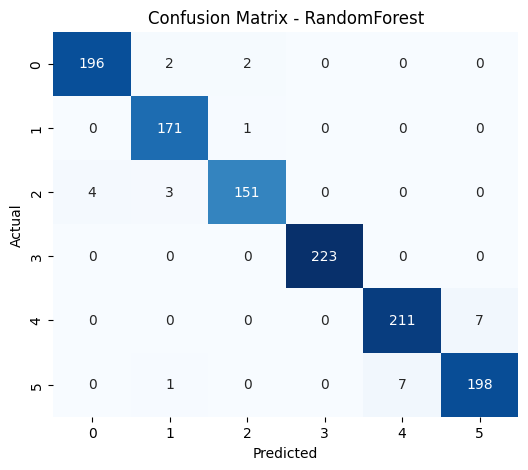


===== LightGBM =====
Accuracy: 0.9907

Classification Report:
              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000   200.000000
1              0.994220  1.000000  0.997101   172.000000
2              1.000000  1.000000  1.000000   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.972727  0.981651  0.977169   218.000000
5              0.980296  0.966019  0.973105   206.000000
accuracy       0.990654  0.990654  0.990654     0.990654
macro avg      0.991207  0.991278  0.991229  1177.000000
weighted avg   0.990655  0.990654  0.990641  1177.000000


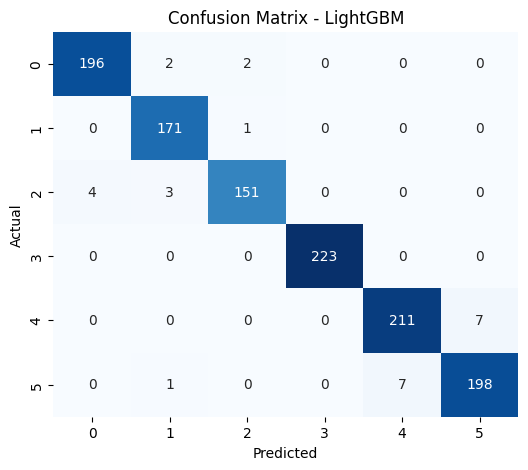


===== XGBoost =====
Accuracy: 0.9907

Classification Report:
              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000   200.000000
1              0.994220  1.000000  0.997101   172.000000
2              1.000000  1.000000  1.000000   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.972727  0.981651  0.977169   218.000000
5              0.980296  0.966019  0.973105   206.000000
accuracy       0.990654  0.990654  0.990654     0.990654
macro avg      0.991207  0.991278  0.991229  1177.000000
weighted avg   0.990655  0.990654  0.990641  1177.000000


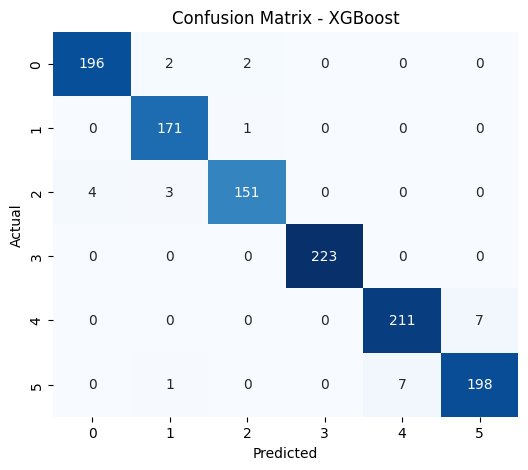


===== CatBoost =====
Accuracy: 0.9907

Classification Report:
              precision    recall  f1-score      support
0              1.000000  1.000000  1.000000   200.000000
1              0.994220  1.000000  0.997101   172.000000
2              1.000000  1.000000  1.000000   158.000000
3              1.000000  1.000000  1.000000   223.000000
4              0.972727  0.981651  0.977169   218.000000
5              0.980296  0.966019  0.973105   206.000000
accuracy       0.990654  0.990654  0.990654     0.990654
macro avg      0.991207  0.991278  0.991229  1177.000000
weighted avg   0.990655  0.990654  0.990641  1177.000000


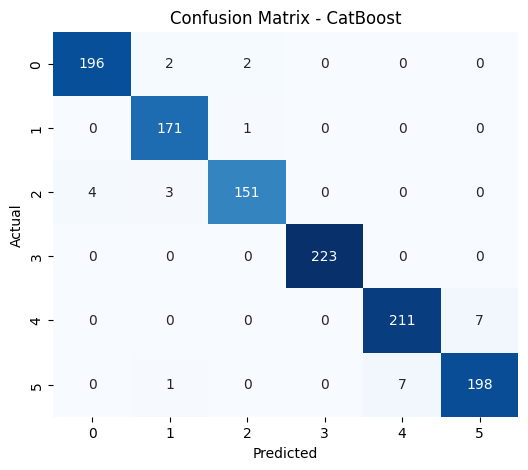

In [137]:
for model_name, result in mm_results.items():
    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {result['accuracy']:.4f}")
    
    print("\nClassification Report:")
    mm_clf_report_df = pd.DataFrame(result['classification_report']).transpose()
    print(mm_clf_report_df)
    
    # Confusion Matrix Plot
    plot_confusion_matrix(result['confusion_matrix'], model_name)

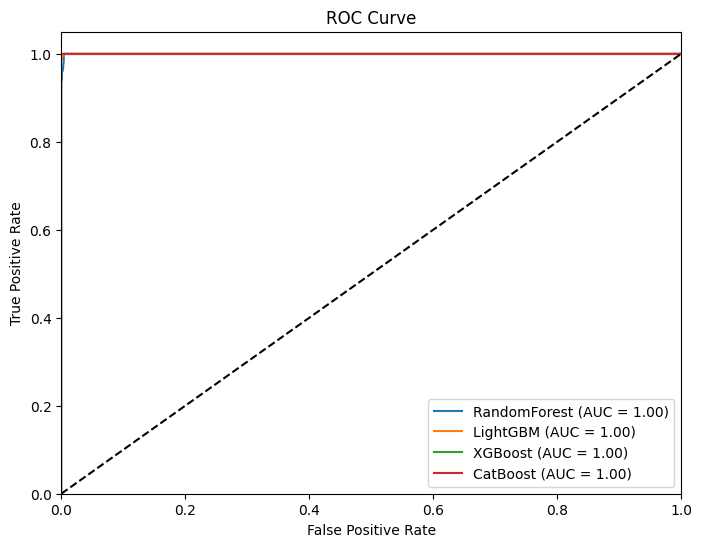

In [138]:
plot_roc_curve(models, X_valid_mm, y_valid)

## MinMaxScaler는 적절하지 않아 보인다.
-> 일관된 분포와 일반화 덕분에 대체적으로 성능이 좋지만 그렇기에 오히려 각 모델의 성능을 제한해버림